# Capstone 3 - Pre-processing and modeling

Can we predict the electricity load for three cities of Panama, considering meteorologic conditions, holidays, and school schedule?

In [1]:
# Modules importation
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import VAR
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importing the dataset
data = pd.read_csv(r'C:\Users\laurence\OneDrive\Data Science\Capstone 3\capstone3_data_EDA.csv')
data.datetime = pd.to_datetime(data.datetime)
data = data.set_index("datetime")

In [3]:
# Droping the 2020 data, affected by the global pandemic.
data = data[(data['year'] != 2020)]

In [4]:
# Resampling on a weekly basis
data_uni_w = data['nat_elec_load'].resample("W").sum()
data_uni_w.drop(data_uni_w.tail(1).index,inplace=True)
data_uni_w.drop(data_uni_w.head(1).index,inplace=True)
data_uni_w = pd.DataFrame(data_uni_w)

In [5]:
# Visualization of end of the dataset to see the last entries
data_uni_w.tail(3)

,nat_elec_load
datetime,
2019-12-15,220102.1454
2019-12-22,225592.3476
2019-12-29,206109.1895


<AxesSubplot:xlabel='datetime'>

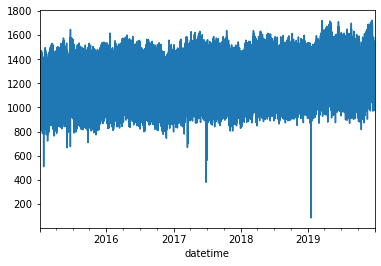

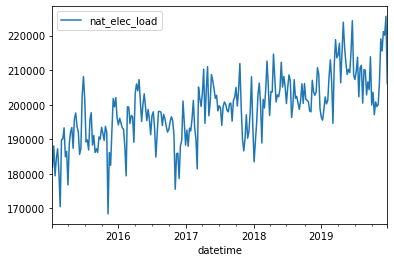

In [6]:
# Visualization of the original and theresampled data on a weekly basis.
data['nat_elec_load'].plot()
data_uni_w.plot()

In [7]:
# Isolating the trend in the time series
seasonal_dec = seasonal_decompose(x=data_uni_w, extrapolate_trend=7)
trend = seasonal_dec.trend
trend = pd.DataFrame(trend)
print(trend.head())
print(trend.tail())

                    trend
datetime                 
2015-01-11  185853.932604
2015-01-18  186022.104902
2015-01-25  186190.277200
2015-02-01  186358.449498
2015-02-08  186526.621797
                    trend
datetime                 
2019-12-01  212894.780917
2019-12-08  213087.371818
2019-12-15  213279.962718
2019-12-22  213472.553619
2019-12-29  213665.144519


<AxesSubplot:xlabel='datetime'>

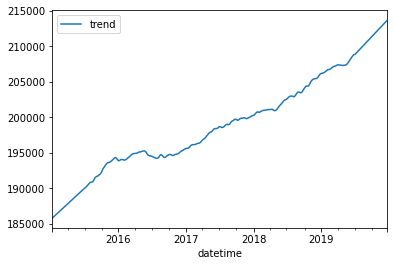

In [8]:
# Visualizing the trend
trend.plot()

<AxesSubplot:xlabel='datetime'>

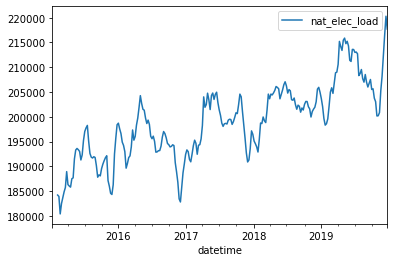

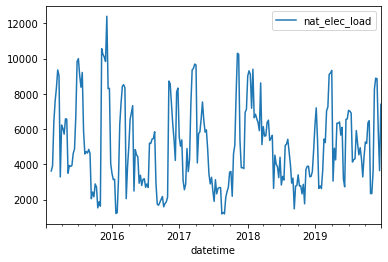

In [9]:
# Verification of the stationarity of the nat_elec_load feature
rolling_mean = data_uni_w.rolling(window = 5).mean()
rolling_std = data_uni_w.rolling(window = 5).std()

rolling_mean.plot()
rolling_std.plot()

The rolling standard deviation is flat, while there is an increase in the rolling mean.

In [10]:
# Augmented Dickey-Fuller test to verify stationarity
adfuller(data_uni_w)

(-2.3280140475257887,
 0.16309197981763768,
 5,
 254,
 {'1%': -3.456360306409983,
  '5%': -2.8729872043802356,
  '10%': -2.572870232500465},
 4926.952670738553)

The p value is over 0.05. The null hypothesis is not rejected, indicating that the data is considered as not stationary.

In [11]:
# Transformation of the data into stationary
data_uni_w["diff_1"] = data_uni_w["nat_elec_load"].diff()
data_uni_w.head()

,nat_elec_load,diff_1
datetime,,
2015-01-11,181919.6224,NaN
2015-01-18,188082.3152,6162.6928
2015-01-25,179448.7184,-8633.5968
2015-02-01,184393.4256,4944.7072
2015-02-08,187290.1846,2896.7590


In [12]:
# Verification of the Dickey-Fuller test on the diff_1
adfuller(data_uni_w["diff_1"].dropna())

(-12.182456448733662,
 1.3418641029022053e-22,
 4,
 254,
 {'1%': -3.456360306409983,
  '5%': -2.8729872043802356,
  '10%': -2.572870232500465},
 4909.081673892859)

The p value is now below 0.05. The null hypothesis is then rejected, indicating that the data is now considered as stationary.

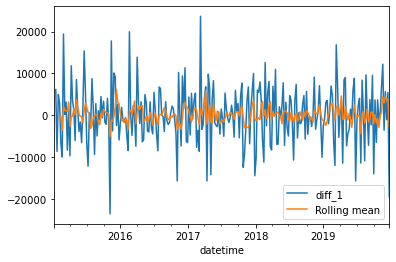

In [13]:
# Visualisation of the diff_1 series to see if it is stationary.
data_uni_w["diff_1"].plot()
data_uni_w['diff_1'].rolling(window = 5).mean().plot(label = 'Rolling mean')
plt.legend()

In [14]:
# Preparation of the new data frame
data_uni_w_diff1 = data_uni_w["diff_1"].dropna()
data_uni_w_diff1 = pd.DataFrame(data_uni_w_diff1)

In [15]:
# Train test split - test dataset corresponding to the 2019 year.
train_uni_diff = data_uni_w_diff1[:207] 
test_uni_diff = data_uni_w_diff1[207:]

## Univariate ARIMA model

In [16]:
# Parameter tuning using stepwise_model
stepwise_model_uni = auto_arima(train_uni_diff, start_p = 0, start_q = 0, test = 'adf', max_p = 10, max_q = 10, m = 1,
                            d = 1, seasonal = False, D = 0, traca = True, error_action = 'ignore',
                            suppress_warnings = True, stepwise = True)

In [17]:
# Printing the Akaike information criterion 
aic_uni = stepwise_model_uni.aic()
aic_uni

4209.285604425432

In [18]:
# Training data using the tuned model
stepwise_model_uni.fit(train_uni_diff)

ARIMA(order=(9, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [19]:
# Making prediction for 2019
future_forecast_uni = stepwise_model_uni.predict(n_periods = 53)
future_forecast_uni = pd.DataFrame(future_forecast_uni, index = test_uni_diff.index, columns = ['Prediction_uni'])

<AxesSubplot:xlabel='datetime'>

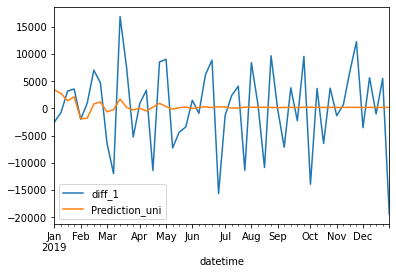

In [20]:
# Visualisation of the transformed real and predicted data
pd.concat([test_uni_diff, future_forecast_uni], axis = 1).plot()

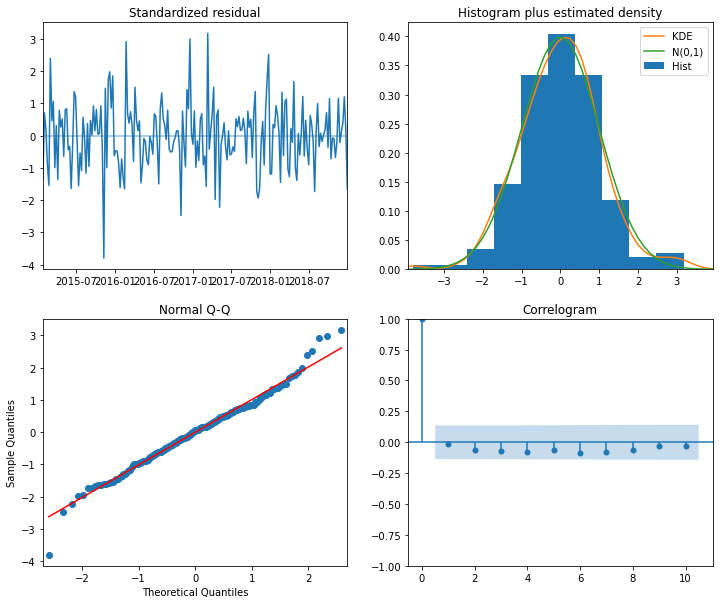

In [21]:
# Visualisation of the model diagnostic
stepwise_model_uni.plot_diagnostics(figsize=(12,10))
plt.show()

In [22]:
# Printing the model summary
print(stepwise_model_uni.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  207
Model:               SARIMAX(9, 1, 0)   Log Likelihood               -2094.643
Date:                Sun, 19 Feb 2023   AIC                           4209.286
Time:                        16:06:11   BIC                           4242.564
Sample:                    01-18-2015   HQIC                          4222.745
                         - 12-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2750      0.063    -20.308      0.000      -1.398      -1.152
ar.L2         -1.5438      0.102    -15.191      0.000      -1.743      -1.345
ar.L3         -1.6232      0.137    -11.874      0.0

In [23]:
# Restoration of the modelized data
resultats = pd.DataFrame()
resultats['retransformed_uni'] = trend['trend'] + (future_forecast_uni['Prediction_uni']).diff(-1)

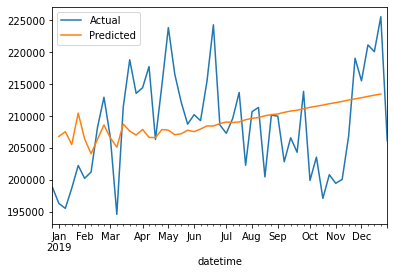

In [24]:
# Comparison of the real and modelized data    
data2019 = data_uni_w['nat_elec_load'][207:]
data2019.plot(label = 'Actual')
resultats['retransformed_uni'][207:].plot(label = 'Predicted')
plt.legend()

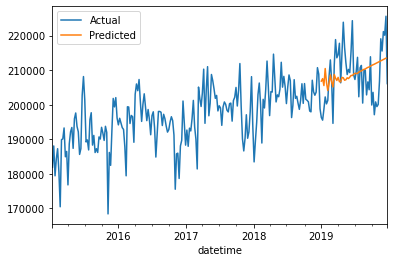

In [25]:
# Comparison of the real and modelized data in context
data_uni_w['nat_elec_load'].plot(label = 'Actual')
resultats['retransformed_uni'].plot(label = 'Predicted')
plt.legend()

In [26]:
# Definition of a function to obtain metrics
def fc_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    me = np.mean(forecast - actual)
    mae = np.mean(np.abs(forecast - actual))
    mpe = np.mean((forecast - actual)/actual)
    rmse = np.mean((forecast - actual)**2)**0.5    
    return({'mape': mape, 'me': me, 'mae': mae, 'mpe': mpe, 'rmse': rmse})

In [27]:
acc_uni = fc_accuracy(resultats['retransformed_uni'], data2019)
acc_uni

{'mape': 0.030777980108414784,
 'me': 286.09047116573237,
 'mae': 6411.354376788328,
 'mpe': 0.0027045644541494967,
 'rmse': 7796.801428328843}

## Multivariate Arima model considering exogenous variables

In [28]:
# Resampling on a weekly basis with the sum or the mean, depending on the feature
data_multi = pd.DataFrame()
data_multi['nat_elec_load'] = data['nat_elec_load'].resample("W").sum()
data_multi['t_toc'] = data['t_toc'].resample("W").mean()
data_multi['h_toc'] = data['h_toc'].resample("W").mean()
data_multi['p_toc'] = data['p_toc'].resample("W").sum()
data_multi['ws_toc'] = data['ws_toc'].resample("W").mean()
data_multi['t_san'] = data['t_san'].resample("W").mean()
data_multi['h_san'] = data['h_san'].resample("W").mean()
data_multi['p_san'] = data['p_san'].resample("W").sum()
data_multi['ws_san'] = data['ws_san'].resample("W").mean()
data_multi['t_dav'] = data['t_dav'].resample("W").mean()
data_multi['h_dav'] = data['h_dav'].resample("W").mean()
data_multi['p_dav'] = data['p_dav'].resample("W").sum()
data_multi['ws_dav'] = data['ws_dav'].resample("W").mean()
data_multi['holiday_ID'] = data['holiday_ID'].resample("W").sum()
data_multi['holiday'] = data['holiday'].resample("W").sum()
data_multi['school'] = data['school'].resample("W").sum()

data_multi.drop(data_multi.tail(1).index,inplace=True)
data_multi.drop(data_multi.head(1).index,inplace=True)
data_multi = pd.DataFrame(data_multi)

data_multi.head()

,nat_elec_load,t_toc,h_toc,p_toc,ws_toc,t_san,h_san,p_san,ws_san,t_dav,h_dav,p_dav,ws_dav,holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2015-01-11,181919.6224,26.829882,0.017483,3.443329,25.429599,25.733156,0.016941,3.995602,13.844652,23.820581,0.015845,17.169937,6.687586,48.0,24.0,0.0
2015-01-18,188082.3152,27.047046,0.017778,7.872233,20.616549,26.108616,0.017291,11.167252,8.728468,24.394144,0.016080,20.262146,3.462595,0.0,0.0,0.0
2015-01-25,179448.7184,26.586434,0.016808,13.071503,18.210324,25.853082,0.016226,13.993546,8.015694,23.845967,0.015266,19.622757,3.004145,0.0,0.0,0.0
2015-02-01,184393.4256,27.024779,0.016309,5.475823,24.159216,26.246552,0.015350,6.404824,12.579642,23.686981,0.014966,15.239387,5.659424,0.0,0.0,0.0
2015-02-08,187290.1846,27.346896,0.017026,5.995931,20.208824,27.558020,0.016060,10.450697,9.342399,24.438553,0.015646,18.350250,3.755133,0.0,0.0,0.0


In [29]:
# Definition of a function to obtain the Dickey-Fuller test results for all features of the dataset.
def adfuller_test(series, signif=0.05):
    x = adfuller(series, autolag='AIC')
    output = {'Test Statistic': x[0], 
              'P-value': x[1], 
              'Number of lags': x[2], 
              'Number of observations': x[3],
              f'Reject (signif. level {signif})': x[1] < signif }
    for key, val in x[4].items():
         output[f'Critical value {key}'] = val
    return pd.Series(output)

In [30]:
data_multi.apply(lambda x: adfuller_test(x), axis=0)

,nat_elec_load,t_toc,h_toc,p_toc,ws_toc,t_san,h_san,p_san,ws_san,t_dav,h_dav,p_dav,ws_dav,holiday_ID,holiday,school
Test Statistic,-2.328014,-4.147768,-4.920268,-3.77971,-4.615757,-4.209354,-5.190418,-4.848723,-4.397102,-4.349681,-5.064249,-4.004139,-5.41961,-3.754414,-4.207352,-3.958252
P-value,0.163092,0.000807,0.000032,0.003122,0.000121,0.000635,0.000009,0.000044,0.0003,0.000364,0.000017,0.001389,0.000003,0.00341,0.00064,0.001646
Number of lags,5,2,9,2,8,0,7,8,2,0,7,2,2,6,6,16
Number of observations,254,257,250,257,251,259,252,251,257,259,252,257,257,253,253,243
Reject (signif. level 0.05),False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Critical value 1%,-3.45636,-3.456054,-3.456781,-3.456054,-3.456674,-3.455853,-3.456569,-3.456674,-3.456054,-3.455853,-3.456569,-3.456054,-3.456054,-3.456464,-3.456464,-3.457551
Critical value 5%,-2.872987,-2.872853,-2.873172,-2.872853,-2.873125,-2.872765,-2.873079,-2.873125,-2.872853,-2.872765,-2.873079,-2.872853,-2.872853,-2.873033,-2.873033,-2.873509
Critical value 10%,-2.57287,-2.572799,-2.572969,-2.572799,-2.572944,-2.572752,-2.572919,-2.572944,-2.572799,-2.572752,-2.572919,-2.572799,-2.572799,-2.572895,-2.572895,-2.573148


As seen before, nat_elec_load is not stationary, but it is the only one non-stationary feature of the dataset. We already know that one degree differenciation is enough to transform the data into stationary.

In [31]:
# Transformation of the data into stationary
data_multi["nat_elec_load_diff_1"] = data_multi["nat_elec_load"].diff()
data_multi_diff1 = data_multi.drop('nat_elec_load', axis=1)
data_multi_diff1 = data_multi_diff1.dropna()

In [32]:
# Train test split - test dataset corresponding to the 2019 year.
train = data_multi_diff1["nat_elec_load_diff_1"][1:207] 
test = data_multi_diff1["nat_elec_load_diff_1"][207:]

exo_train = data_multi_diff1.drop("nat_elec_load_diff_1", axis = 1)[1:207]
exo_test = data_multi_diff1.drop("nat_elec_load_diff_1", axis = 1)[207:]

In [33]:
stepwise_model_multi_exo = auto_arima(train, exogenous = exo_train, start_p = 0, start_q = 0, test = 'adf', max_p = 10, max_q = 10,
                            m = 1, d = 1, seasonal = False, D = 0, traca = True, error_action = 'ignore', 
                            suppress_warnings = True, stepwise = True)

In [34]:
# Printing the Akaike information criterion 
aic_multi_exo = stepwise_model_multi_exo.aic()
aic_multi_exo

4190.320244179753

In [35]:
# Training data using the model
stepwise_model_multi_exo.fit(train)

ARIMA(order=(9, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [36]:
# Making prediction for 2019
future_forecast_multi_exo = stepwise_model_multi_exo.predict(n_periods=53, exogenous = exo_test)
future_forecast_multi_exo = pd.DataFrame(future_forecast_multi_exo, index = test.index, columns = ['Prediction_multi_exo'])

<AxesSubplot:xlabel='datetime'>

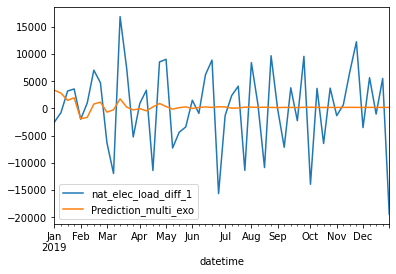

In [37]:
# Visualisation of the transformed real and predicted data
pd.concat([test, future_forecast_multi_exo], axis = 1).plot()

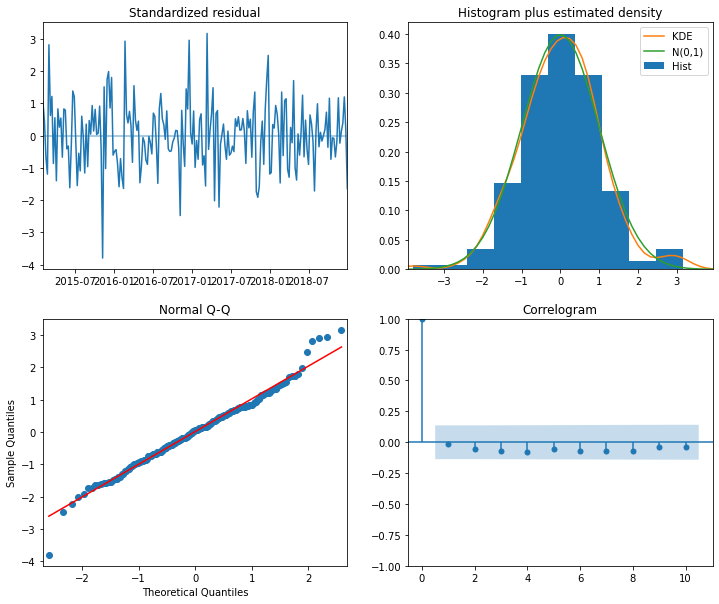

In [38]:
# Visualisation of the model diagnostic
stepwise_model_multi_exo.plot_diagnostics(figsize=(12,10))
plt.show()

In [39]:
# Printing the model summary
print(stepwise_model_multi_exo.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  206
Model:               SARIMAX(9, 1, 0)   Log Likelihood               -2085.160
Date:                Sun, 19 Feb 2023   AIC                           4190.320
Time:                        16:07:14   BIC                           4223.550
Sample:                    01-25-2015   HQIC                          4203.761
                         - 12-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2678      0.063    -20.136      0.000      -1.391      -1.144
ar.L2         -1.5369      0.101    -15.250      0.000      -1.734      -1.339
ar.L3         -1.6156      0.137    -11.811      0.0

In [40]:
# Restoration of the modelized data
resultats['retransformed_multi_exo'] = trend['trend'] + (future_forecast_multi_exo['Prediction_multi_exo']).diff(-1)

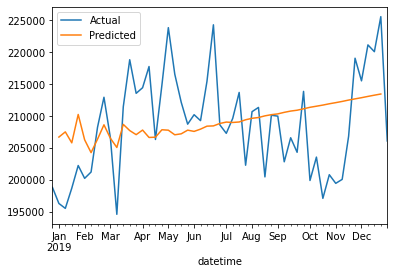

In [41]:
# Comparison of the real and modelized data    
data2019.plot(label = 'Actual')
resultats['retransformed_multi_exo'][207:].plot(label = 'Predicted')
plt.legend()

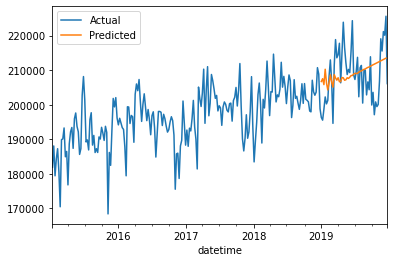

In [42]:
# Comparison of the real and modelized data in context
data_uni_w['nat_elec_load'].plot(label = 'Actual')
resultats['retransformed_multi_exo'].plot(label = 'Predicted')
plt.legend()

In [43]:
acc_multi_exo = fc_accuracy(resultats['retransformed_multi_exo'], data2019)
acc_multi_exo

{'mape': 0.030778726850098997,
 'me': 285.13739109993054,
 'mae': 6411.573152600509,
 'mpe': 0.00269951021175906,
 'rmse': 7790.768599356121}

## Multivariate Arima model (seasonal_index as the exogenous feature)

In [89]:
# Obtaining the seasonal index
seasonal_dec = seasonal_decompose(x=data_uni_w['nat_elec_load'], model = 'additive', extrapolate_trend='freq')
seasonal_index = seasonal_dec.seasonal[207:].to_frame()

In [90]:
stepwise_model_multi_si = auto_arima(train, exogenous = seasonal_index, start_p = 0, start_q = 0, test = 'adf', max_p = 10, max_q = 10,
                            m = 1, d = 1, seasonal = False, D = 0, traca = True, error_action = 'ignore', 
                            suppress_warnings = True, stepwise = True)

In [91]:
# Printing the Akaike information criterion 
aic_multi_si = stepwise_model_multi_si.aic()
aic_multi_si

4190.320244179753

In [51]:
# Training data using the model
stepwise_model_multi_si.fit(train)

ARIMA(order=(9, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [52]:
# Making prediction for 2019
future_forecast_multi_si = stepwise_model_multi_si.predict(n_periods=53, exogenous = seasonal_index)
future_forecast_multi_si = pd.DataFrame(future_forecast_multi_si, index = test.index, columns = ['Prediction_multi_si'])

<AxesSubplot:xlabel='datetime'>

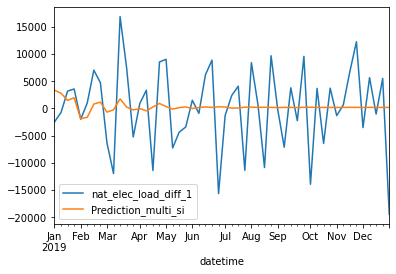

In [53]:
# Visualisation of the transformed real and predicted data
pd.concat([test, future_forecast_multi_si], axis = 1).plot()

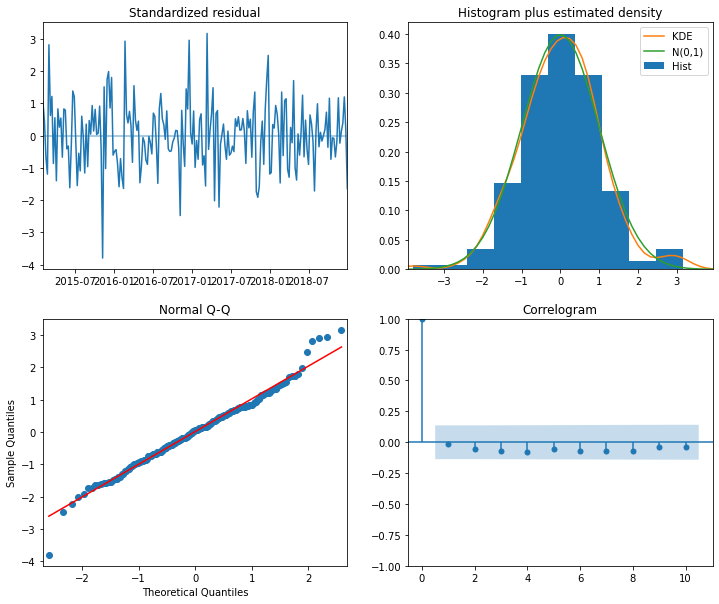

In [54]:
# Visualisation of the model diagnostic
stepwise_model_multi_si.plot_diagnostics(figsize=(12,10))
plt.show()

In [55]:
# Printing the model summary
print(stepwise_model_multi_si.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  206
Model:               SARIMAX(9, 1, 0)   Log Likelihood               -2085.160
Date:                Sun, 19 Feb 2023   AIC                           4190.320
Time:                        16:11:15   BIC                           4223.550
Sample:                    01-25-2015   HQIC                          4203.761
                         - 12-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2678      0.063    -20.136      0.000      -1.391      -1.144
ar.L2         -1.5369      0.101    -15.250      0.000      -1.734      -1.339
ar.L3         -1.6156      0.137    -11.811      0.0

In [56]:
# Restoration of the modelized data
resultats['retransformed_multi_si'] = trend['trend'] + (future_forecast_multi_si['Prediction_multi_si']).diff(-1)

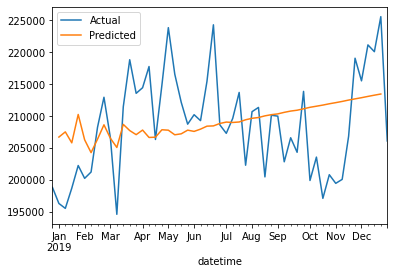

In [57]:
# Comparison of the real and modelized data    
data2019.plot(label = 'Actual')
resultats['retransformed_multi_si'][207:].plot(label = 'Predicted')
plt.legend()

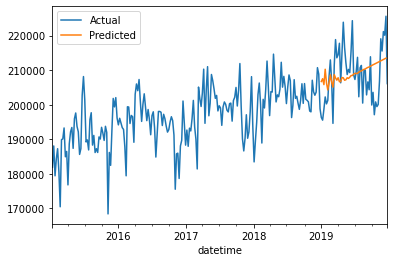

In [58]:
# Comparison of the real and modelized data in context
data_uni_w['nat_elec_load'].plot(label = 'Actual')
resultats['retransformed_multi_si'].plot(label = 'Predicted')
plt.legend()

In [59]:
acc_multi_si = fc_accuracy(resultats['retransformed_multi_si'], data2019)
acc_multi_si

{'mape': 0.030778726850098997,
 'me': 285.13739109993054,
 'mae': 6411.573152600509,
 'mpe': 0.00269951021175906,
 'rmse': 7790.768599356121}

## VAR model

In [60]:
# Initiating the VAR model using all available data and the differentiated target data
var_model = VAR(data_multi_diff1)

In [61]:
# Selecting the appropriate lag of the model
order = var_model.select_order()
order.summary()

,AIC,BIC,FPE,HQIC
0,-4.335,-4.106,0.01310,-4.243
1,-10.14,-6.250*,3.974e-05,-8.571
2,-10.05,-2.501,4.451e-05,-7.008
3,-9.672,1.532,6.876e-05,-5.161
4,-9.225,5.638,0.0001214,-3.240
5,-9.124,9.397,0.0001648,-1.666
6,-9.301,12.88,0.0001900,-0.3693
7,-9.233,16.60,0.0003261,1.172
8,-9.561,19.94,0.0004624,2.317
9,-9.705,23.45,0.001040,3.646


14 lags, showing the most minimum values, was selected for modeling.

In [62]:
# Fiting the model using 14 lags
var_results = var_model.fit(14)
var_results.summary()
lag_order = var_results.k_ar

In [63]:
# Making prediction for 2019
future_forecast_var = var_results.forecast(data_multi_diff1.values[-lag_order:], 53)
future_forecast_var = pd.DataFrame(future_forecast_var)
future_forecast_var.columns = ['t_toc', 'h_toc', 'p_toc', 'ws_toc', 't_san', 'h_san', 'p_san', 'ws_san', 't_dav', 'h_dav',
                            'p_dav', 'ws_dav', 'holiday_ID', 'holiday', 'school', 'nat_elec_load_diff_1']
prediction_var = future_forecast_var['nat_elec_load_diff_1']

In [64]:
date = ['2018-12-30', '2019-01-06', '2019-01-13', '2019-01-20', '2019-01-27', '2019-02-03', '2019-02-10', '2019-02-17',
        '2019-02-24', '2019-03-03', '2019-03-10', '2019-03-17', '2019-03-24', '2019-03-31', '2019-04-07', '2019-04-14',
        '2019-04-21', '2019-04-28', '2019-05-05', '2019-05-12', '2019-05-19', '2019-05-26', '2019-06-02', '2019-06-09',
        '2019-06-16', '2019-06-23', '2019-06-30', '2019-07-07', '2019-07-14', '2019-07-21', '2019-07-28', '2019-08-04',
        '2019-08-11', '2019-08-18', '2019-08-25', '2019-09-01', '2019-09-08', '2019-09-15', '2019-09-22', '2019-09-29',
        '2019-10-06', '2019-10-13', '2019-10-20', '2019-10-27', '2019-11-03', '2019-11-10', '2019-11-17', '2019-11-24',
        '2019-12-01', '2019-12-08', '2019-12-15', '2019-12-22', '2019-12-29']
date = pd.DataFrame(date, columns = ['datetime'])

In [65]:
prediction_var = pd.concat([date, prediction_var], axis = 1)
prediction_var.datetime = pd.to_datetime(prediction_var.datetime)
prediction_var = prediction_var.set_index("datetime")
prediction_var.columns = ['Prediction_var']

<AxesSubplot:xlabel='datetime'>

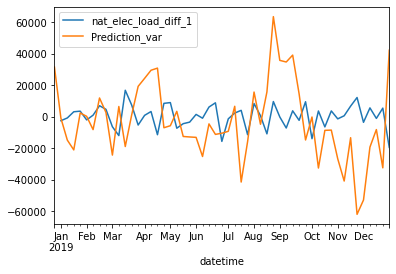

In [66]:
# Visualisation of the transformed real and predicted data
pd.concat([test, prediction_var], axis = 1).plot()

In [67]:
# Restoration of the modelized data
resultats['retransformed_var'] = trend['trend'] + (prediction_var['Prediction_var'].diff(-1))

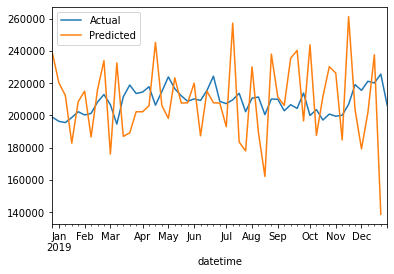

In [68]:
# Comparison of the real and modelized data    
data2019.plot(label = 'Actual')
resultats['retransformed_var'][207:].plot(label = 'Predicted')
plt.legend()

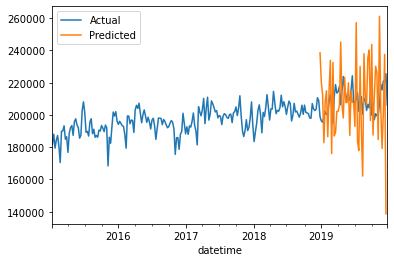

In [69]:
# Comparison of the real and modelized data in context
data_uni_w['nat_elec_load'].plot(label = 'Actual')
resultats['retransformed_var'].plot(label = 'Predicted')
plt.legend()

In [70]:
acc_var = fc_accuracy(resultats['retransformed_var'], data2019)
acc_var

{'mape': 0.10524937675288853,
 'me': 150.93513820250575,
 'mae': 21938.135560141967,
 'mpe': 0.0030270202386503066,
 'rmse': 26880.982115891577}

## VAR model using less lag (n = 6)

In [71]:
# Fiting the model using 14 lags
var_results_6lags = var_model.fit(6)
var_results_6lags.summary()
lag_order_6lags = var_results_6lags.k_ar

In [72]:
# Making prediction for 2019
future_forecast_var6lags = var_results_6lags.forecast(data_multi_diff1.values[-lag_order:], 53)
future_forecast_var6lags = pd.DataFrame(future_forecast_var6lags)
future_forecast_var6lags.columns = ['t_toc', 'h_toc', 'p_toc', 'ws_toc', 't_san', 'h_san', 'p_san', 'ws_san', 't_dav', 'h_dav',
                            'p_dav', 'ws_dav', 'holiday_ID', 'holiday', 'school', 'nat_elec_load_diff_1']
prediction_var6lags = future_forecast_var6lags['nat_elec_load_diff_1']

In [73]:
prediction_var6lags = pd.concat([date, prediction_var6lags], axis = 1)
prediction_var6lags.datetime = pd.to_datetime(prediction_var6lags.datetime)
prediction_var6lags = prediction_var6lags.set_index("datetime")
prediction_var6lags.columns = ['Prediction_var6lags']

<AxesSubplot:xlabel='datetime'>

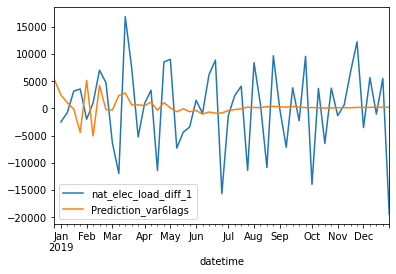

In [74]:
# Visualisation of the transformed real and predicted data
pd.concat([test, prediction_var6lags], axis = 1).plot()

In [75]:
# Restoration of the modelized data
resultats['retransformed_var6lags'] = trend['trend'] + (prediction_var6lags['Prediction_var6lags'].diff(-1))

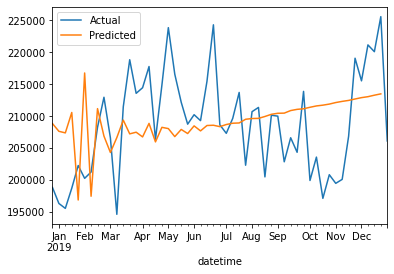

In [76]:
# Comparison of the real and modelized data    
data2019.plot(label = 'Actual')
resultats['retransformed_var6lags'][207:].plot(label = 'Predicted')
plt.legend()

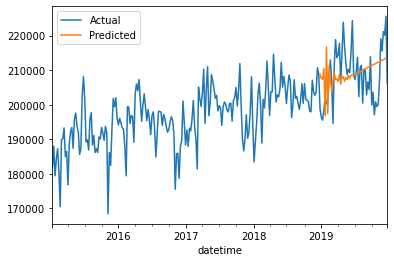

In [77]:
# Comparison of the real and modelized data in context
data_uni_w['nat_elec_load'].plot(label = 'Actual')
resultats['retransformed_var6lags'].plot(label = 'Predicted')
plt.legend()

In [78]:
acc_var6lags = fc_accuracy(resultats['retransformed_var6lags'], data2019)
acc_var6lags

{'mape': 0.03290518080983833,
 'me': 455.18988687087796,
 'mae': 6829.467570581925,
 'mpe': 0.0035413327466763582,
 'rmse': 8235.785693970694}

## Model review

In [79]:
# Combining all the accuracy results in a single data frame
acc_results = pd.DataFrame()
acc_results['metrics'] = ['mape', 'me', 'mae', 'mpe', 'rmse']
acc_results = acc_results.set_index('metrics')
acc_results['acc_uni'] = acc_uni.values()
acc_results['acc_multi_exo'] = acc_multi_exo.values()
acc_results['acc_multi_si'] = acc_multi_si.values()
acc_results['acc_var'] = acc_var.values()
acc_results['acc_var6lags'] = acc_var6lags.values()
acc_results

,acc_uni,acc_multi_exo,acc_multi_si,acc_var,acc_var6lags
metrics,,,,,
mape,0.030778,0.030779,0.030779,0.105249,0.032905
me,286.090471,285.137391,285.137391,150.935138,455.189887
mae,6411.354377,6411.573153,6411.573153,21938.135560,6829.467571
mpe,0.002705,0.002700,0.002700,0.003027,0.003541
rmse,7796.801428,7790.768599,7790.768599,26880.982116,8235.785694


<AxesSubplot:xlabel='metrics'>

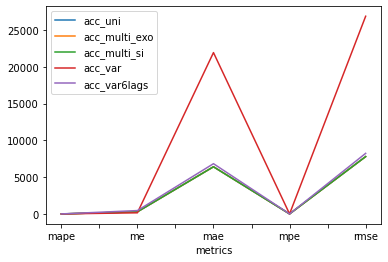

In [80]:
acc_results.plot()

In [81]:
print('aic_uni:', aic_uni)
print('aic_multi_exo:', aic_multi_exo)
print('aic_multi_si:', aic_multi_si)

aic_uni: 4209.285604425432
aic_multi_exo: 4190.320244179753
aic_multi_si: 4190.320244179753


<AxesSubplot:xlabel='datetime'>

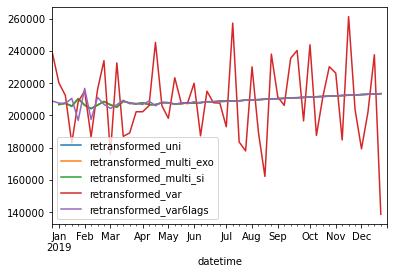

In [85]:
# Visualization of all the predictions
resultats[207:].plot()

 ### Conclusions
- Both multivariable ARIMA models give exactly the same metrics and results. This should be linked to a very negligeable impact of the exogenous variables considered on target modeling, or this could also be linked to a misapplication of the models.
- There is no pattern in the residual values when using both univariable and multivariables ARIMA.
- The KDE is mostly symmetrical in both univariable and multivariables ARIMA models, but with a little skew towards higher values. This is more evident for multivariable ARIMA models.
- The BIC is a little lower for multivariable ARIMA models (4223.550) than for the univariable ARIMA (4242.564).
- The VAR model with the prescribed number of lags (n = 14) predict very noisy and not meaningful data, and seems very prone to overfitting. 
- The VAR using less lags (n = 6) is noisy at the beginning, but is very similar to the ARIMA models after 3 months.
- Considering the accuracy metrics, all models give very similar results except for the VAR with 14 lags, having significantly higher MAE and RMSE values.
- In this context, it make sens to use the univariable ARIMA model for forecasting.